# Spreadsheet for advanced cannons #

Using data from https://fromthedepths.gamepedia.com/index.php?title=Advanced_Cannon&oldid=8383

In [1]:
from sympy import *
import math
from IPython.display import HTML, display, Math, Latex
import ftd_calc as FTD
init_printing()

# Analytic study for kinetic damage #

Caclulating symbolic value for DPS, given parameters:

- diameter, `diameter`=$D$
- total number of modules (with casings), `modules`=$N$
- number of gunpowder casings `propellant`=$Np$
- number of rail casings `rail`=$Nr$
- rail charge `charge`=$Q$

In [2]:
# These are 'magic' symbols from sympy. Any arithmetic operations
# on this values will produce symbolic formulas.
diameter = symbols("D", positive=True)
numExplosive, modules, propellant, rail = symbols('Ne N Np Nr', positive=True)
charge = symbols("Q")

Feeding our magic values to DPS calculator

In [3]:
data = FTD.calcWeaponDPS({
    "diameter": diameter, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": 1.0,
    "kineticC": 1.0,
    "armorC": 1,
    "rails": rail,
    "loaders": 1,
    "clipsPerLoader": 3,
    "velCharge": charge
})
dps = data["dps"]
data

{'damage': {'kinetic': (23.0670208647647*D**1.95*(1.05737126344056*D**(-0.75)*Q**0.5*(6.0 - 5.0*0.9**Nr)*(N - Np - Nr)**(-0.25) + 868.681853770701*D**0.09*Np*(N - Np - Nr)**0.03/N)*(N - Np - Nr)**0.65,
   0.00845897010752451*D**(-0.75)*Q**0.5*(6.0 - 5.0*0.9**Nr)*(N - Np - Nr)**(-0.25) + 6.9494548301656*D**0.09*Np*(N - Np - Nr)**0.03/N)},
 'dps': 0.901648346931288*D**0.45*N**(-0.5)*(1.05737126344056*D**(-0.75)*Q**0.5*(6.0 - 5.0*0.9**Nr)*(N - Np - Nr)**(-0.25) + 868.681853770701*D**0.09*Np*(N - Np - Nr)**0.03/N)*(N - Np - Nr)**0.65,
 'period': 25.5831676986622*D**1.5*N**0.5,
 'vp': 694.94548301656*D**0.09*Np*(N - Np - Nr)**0.03/N,
 'vr': 0.845897010752451*D**(-0.75)*Q**0.5*(6.0 - 5.0*0.9**Nr)*(N - Np - Nr)**(-0.25)}

DPS formula is:

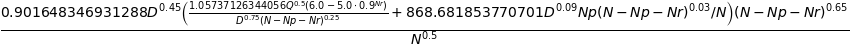

In [12]:
 data["dps"]

## Partial derrivatives ##

Let's calculate partial derrivateves. It will provide us some insight how these values will influence effective DPS:

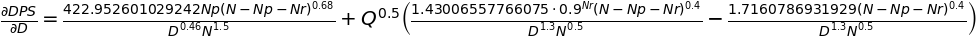

In [4]:
Eq(Symbol('\\frac{\\partial DPS}{\\partial D}'), collect(diff(expand(dps), diameter), charge))

This result is controversal. If you have no rail charge, then increasing diameter certainly increases your effective DPS. If you have some rail charge, then increasing your diameter makes your DPS worse.

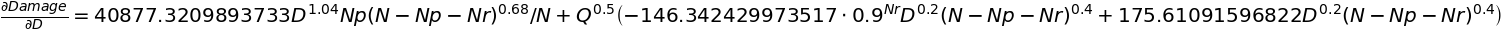

In [5]:
Eq(Symbol('\\frac{\\partial Damage}{\\partial D}'), collect(diff(expand(data['damage']['kinetic'][0]), diameter), charge))

This derrivative is positive function. Seems like actual DPS for rails is being reduced by reloading time.

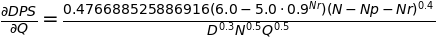

In [6]:
Eq(Symbol('\\frac{\\partial DPS}{\\partial Q}'), diff(dps, charge))

This derrivateve is strictly positive. It means that increasing rail charge never hurts you

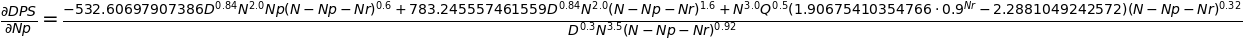

In [7]:
Eq(Symbol('\\frac{\\partial DPS}{\\partial Np}'), simplify(expand(diff(dps, propellant))))

This derrivateve is ... complicated. We could try to calculate optimumm for propellant charges, but it is more convenient to leave it to dynamic optimizer.

## Rail boost for propellant-only shells ##

In [8]:
data_prop = FTD.calcWeaponDPS({
    "diameter": diameter, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": 1.0,
    "kineticC": 1.0,
    "armorC": 1,
    "rails": 0,
    "loaders": 1,
    "clipsPerLoader": 3,
    "velCharge": charge
})
dps_prop = data_prop['dps']

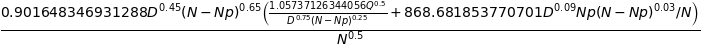

In [9]:
dps_prop

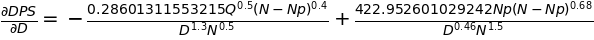

In [10]:
Eq(Symbol('\\frac{\\partial DPS}{\\partial D}'), collect(diff(expand(dps_prop), diameter), charge))

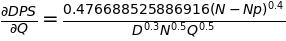

In [11]:
Eq(Symbol('\\frac{\\partial DPS}{\\partial Q}'), diff(dps_prop, charge))

Though returns are certainly diminishing, but this derivative is positive function. If you have spare energy - feel free to pump it to your cannon.